# Visualizations for Trees Seminar

##### The goal of this notebook is to produce visualizations for the outputs of the ensembles for our empirical analysis to present in the Trees Seminar on October 20. 

##### The ensembles were generated were intentionally biased with respect to some selected partisan metrics for evaluating the fairness of a districting plan--efficiency gap, mean-median, partisan gini, partisan bias, and mean-thirdian. 

### 2016 Presidential Election in Pennsyvlania Visualizations

Setting up...

In [2]:
## from load_biased_chain_run_hp.py script (see https://github.com/hamiltonw/MRC_redistricting)

import pickle
from functools import partial
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt 
from gerrychain import (GeographicPartition, Graph, MarkovChain,
                        updaters, constraints, Election, accept)
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters.tally import DataTally
import gerrychain.metrics.partisan as pm
import hypothesis_test as hp
from settings import party_to_favor, election_name, bias_measure
import utils

In [3]:
## will use this election as an updater

election = Election(
    "2016 Presidential",
    {"Democratic": "T16PRES_D", "Republican": "T16PRES_R"},
    alias="2016_PRES"
)

In [4]:
pa_vtds = gpd.read_file("./data/PA/PA.shp")
graph = Graph.from_geodataframe(pa_vtds)
del pa_vtds
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population"), "2016_PRES":election} ## manually added election data for 2016 to test Election Object
my_updaters.update(utils.get_elections(party_to_favor, election_name))
initial_partition = GeographicPartition(graph, assignment="CD_2011", updaters=my_updaters)
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i


[('PRES16', ['Republican', 'Democratic'])]


Next we load three previously saved biased chains for this race in Pennsylvania, each of which ran for 10,000 steps--PRES16R, PRES16D, PRES16. 

We store their partitions which represent districting plans that are heavily biased towards a particular party with respect to the partisan metrics mentioned above.

In [5]:
## load biased chains

with open('/Users/edmonds.110/MRC/MRC_redistricting/chains/PRES16_Republican_efficiency_gap_10000.pkl', 'rb') as f:
    all_assignments_PRES16R = pickle.load(f)

with open('/Users/edmonds.110/Downloads/PRES16_Democratic_efficiency_gap_10000_1665635805.pkl', 'rb') as f:
    all_assignments_PRES16D = pickle.load(f)

with open('/Users/edmonds.110/Downloads/unbiased_PRES16_Republican_efficiency_gap_1000000_0_1666052758_shorter.pkl', 'rb') as f:
    all_assignments_PRES16U = pickle.load(f)

In [11]:
## store all districting plans from saved ensembles as geographic partitions in a list

all_partitions_PRES16R = [] # keep track of all the partitions in the saved ensemble
all_partitions_PRES16D = []
all_partitions_PRES16U = []

for idx in range(10000):
    all_partitions_PRES16R.append(GeographicPartition(graph, all_assignments_PRES16R[idx], updaters=my_updaters))
    all_partitions_PRES16D.append(GeographicPartition(graph, all_assignments_PRES16D[0][idx], updaters=my_updaters))
    all_partitions_PRES16U.append(GeographicPartition(graph, all_assignments_PRES16U[0][idx], updaters=my_updaters))

In [12]:
from biased_accept import get_elec_results

In [13]:
party_to_favor = "Democratic"

mean_median_PRES16D = []
partisan_bias_PRES16D = []
partisan_gini_PRES16D = []
mean_thirdian_PRES16D = []
efficiency_gaps_PRES16D = []

for partition in all_partitions_PRES16D:
    elec_result = get_elec_results(partition)
    mean_median_PRES16D.append(elec_result.mean_median())
    partisan_bias_PRES16D.append(elec_result.partisan_bias())
    partisan_gini_PRES16D.append(elec_result.partisan_gini())
    mean_thirdian_PRES16D.append(elec_result.mean_thirdian())
    efficiency_gaps_PRES16D.append(elec_result.efficiency_gap())

######

data_mm_PRES16D = pd.DataFrame(mean_median_PRES16D) 
data_pb_PRES16D = pd.DataFrame(partisan_bias_PRES16D) 
data_pg_PRES16D = pd.DataFrame(partisan_gini_PRES16D) 
data_mt_PRES16D = pd.DataFrame(mean_thirdian_PRES16D) 
data_eg_PRES16D = pd.DataFrame(efficiency_gaps_PRES16D)

## make data frame containing all partisan metrics

PRES16D_partisan_metrics = {"efficiency_gap": efficiency_gaps_PRES16D, 
                            "mean_median": mean_median_PRES16D,
                            "mean_thirdian": mean_thirdian_PRES16D, 
                            "partisan_bias": partisan_bias_PRES16D,
                            "partisan_gini": partisan_gini_PRES16D}

data_pm_PRES16D = pd.DataFrame.from_dict(PRES16D_partisan_metrics)

all_percents_PRES16D = [] # keep track of the democratic percentages
all_safe_seats_PRES16D = []
all_party_seats_PRES16D = []

for partition in all_partitions_PRES16D:
    all_percents_PRES16D.append(sorted(partition[election_name].percents(party_to_favor)))
    
    safe_seats = len([x for x in partition[election_name].percents(party_to_favor) if x > 0.53])
    all_safe_seats_PRES16D.append(safe_seats)

    all_party_seats_PRES16D.append(elec_result.seats(party_to_favor))

## make dataframes for percents and seats

data_percents_PRES16D = pd.DataFrame(all_percents_PRES16D) 
data_safe_seats_PRES16D = pd.DataFrame(all_safe_seats_PRES16D)
data_party_seats_PRES16D = pd.DataFrame(all_party_seats_PRES16D)

PRES16D_seats = {"safe seats": all_safe_seats_PRES16D, "party seats": all_party_seats_PRES16D}

data_seats_PRES16D = pd.DataFrame.from_dict(PRES16D_seats)

In [14]:
party_to_favor = "Republican"

mean_median_PRES16R = []
partisan_bias_PRES16R = []
partisan_gini_PRES16R = []
mean_thirdian_PRES16R = []
efficiency_gaps_PRES16R = []

for partition in all_partitions_PRES16R:
    elec_result = get_elec_results(partition)
    mean_median_PRES16R.append(elec_result.mean_median())
    partisan_bias_PRES16R.append(elec_result.partisan_bias())
    partisan_gini_PRES16R.append(elec_result.partisan_gini())
    mean_thirdian_PRES16R.append(elec_result.mean_thirdian())
    efficiency_gaps_PRES16R.append(elec_result.efficiency_gap())

######

data_mm_PRES16R = pd.DataFrame(mean_median_PRES16R) 
data_pb_PRES16R = pd.DataFrame(partisan_bias_PRES16R) 
data_pg_PRES16R = pd.DataFrame(partisan_gini_PRES16R) 
data_mt_PRES16R = pd.DataFrame(mean_thirdian_PRES16R) 
data_eg_PRES16R = pd.DataFrame(efficiency_gaps_PRES16R)

## make data frame containing all partisan metrics

PRES16R_partisan_metrics = {"efficiency_gap": efficiency_gaps_PRES16R, 
                            "mean_median": mean_median_PRES16R,
                            "mean_thirdian": mean_thirdian_PRES16R, 
                            "partisan_bias": partisan_bias_PRES16R,
                            "partisan_gini": partisan_gini_PRES16R}

data_pm_PRES16R = pd.DataFrame.from_dict(PRES16R_partisan_metrics)

all_percents_PRES16R = [] # keep track of the democratic percentages
all_safe_seats_PRES16R = []
all_party_seats_PRES16R = []

for partition in all_partitions_PRES16R:
    all_percents_PRES16R.append(sorted(partition[election_name].percents(party_to_favor)))
    
    safe_seats = len([x for x in partition[election_name].percents(party_to_favor) if x > 0.53])
    all_safe_seats_PRES16R.append(safe_seats)

    all_party_seats_PRES16R.append(elec_result.seats(party_to_favor))

## make dataframes for percents and seats

data_percents_PRES16R = pd.DataFrame(all_percents_PRES16R) 
data_safe_seats_PRES16R = pd.DataFrame(all_safe_seats_PRES16R)
data_party_seats_PRES16R = pd.DataFrame(all_party_seats_PRES16R)

PRES16R_seats = {"safe seats": all_safe_seats_PRES16R, "party seats": all_party_seats_PRES16R}

data_seats_PRES16R = pd.DataFrame.from_dict(PRES16R_seats)

In [15]:
party_to_favor = ""

mean_median_PRES16U = []
partisan_bias_PRES16U = []
partisan_gini_PRES16U = []
mean_thirdian_PRES16U = []
efficiency_gaps_PRES16U = []

for partition in all_partitions_PRES16U:
    elec_result = get_elec_results(partition)
    mean_median_PRES16U.append(elec_result.mean_median())
    partisan_bias_PRES16U.append(elec_result.partisan_bias())
    partisan_gini_PRES16U.append(elec_result.partisan_gini())
    mean_thirdian_PRES16U.append(elec_result.mean_thirdian())
    efficiency_gaps_PRES16U.append(elec_result.efficiency_gap())

######

data_mm_PRES16U = pd.DataFrame(mean_median_PRES16U) 
data_pb_PRES16U = pd.DataFrame(partisan_bias_PRES16U) 
data_pg_PRES16U = pd.DataFrame(partisan_gini_PRES16U) 
data_mt_PRES16U = pd.DataFrame(mean_thirdian_PRES16U) 
data_eg_PRES16U = pd.DataFrame(efficiency_gaps_PRES16U)

## make data frame containing all partisan metrics

PRES16U_partisan_metrics = {"efficiency_gap": efficiency_gaps_PRES16U, 
                            "mean_median": mean_median_PRES16U,
                            "mean_thirdian": mean_thirdian_PRES16U, 
                            "partisan_bias": partisan_bias_PRES16U,
                            "partisan_gini": partisan_gini_PRES16U}

data_pm_PRES16U = pd.DataFrame.from_dict(PRES16U_partisan_metrics)

all_percents_PRES16DU = [] # keep track of the democratic percentages
all_percents_PRES16RU = [] # keep track of the republican percentages
#all_safe_seats_PRES16U = []
all_party_seats_PRES16DU = []
all_party_seats_PRES16RU = []

for partition in all_partitions_PRES16U:
    all_percents_PRES16DU.append(sorted(partition[election_name].percents("Democratic")))
    all_percents_PRES16RU.append(sorted(partition[election_name].percents("Republican")))
    
    #safe_seats = len([x for x in partition[election_name].percents(party_to_favor) if x > 0.53])
    #all_safe_seats_PRES16U.append(safe_seats)

    all_party_seats_PRES16DU.append(elec_result.seats("Democratic"))
    all_party_seats_PRES16RU.append(elec_result.seats("Republican"))

## make dataframes for percents and seats

data_percents_PRES16DU = pd.DataFrame(all_percents_PRES16DU)
data_percents_PRES16RU = pd.DataFrame(all_percents_PRES16RU)  
#data_safe_seats_PRES16R = pd.DataFrame(all_safe_seats_PRES16R)
data_party_seats_PRES16DU = pd.DataFrame(all_party_seats_PRES16DU)
data_party_seats_PRES16RU = pd.DataFrame(all_party_seats_PRES16RU)

PRES16U_seats = {"party seats Dem": all_party_seats_PRES16DU, "party seats Rep": all_party_seats_PRES16DU}

data_seats_PRES16U = pd.DataFrame.from_dict(PRES16U_seats)

In [22]:
PRES16_eg = {"Democratic": efficiency_gaps_PRES16D, "Republician": efficiency_gaps_PRES16R, "Unbiased": efficiency_gaps_PRES16U}

data_eg_PRES16 = pd.DataFrame.from_dict(PRES16_eg)

Text(0.5, 0, 'Efficiency Gap')

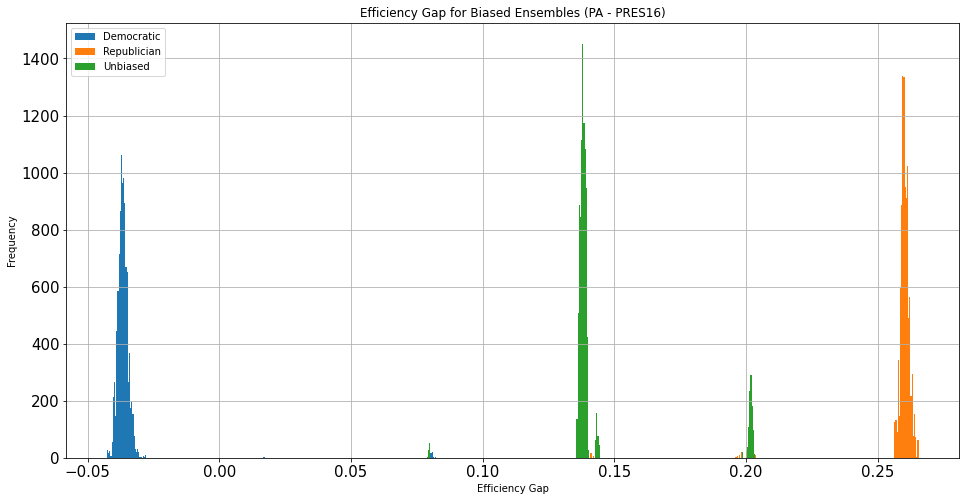

In [23]:
data_eg_PRES16.plot(kind='hist',
                    bins=700,
                    title = "Efficiency Gap for Biased Ensembles (PA - PRES16)",
                    grid=True,
                    figsize = (16,8),
                    fontsize = 15)

plt.xlabel('Efficiency Gap')


array([[<AxesSubplot:title={'center':'Democratic'}>,
        <AxesSubplot:title={'center':'Republician'}>],
       [<AxesSubplot:title={'center':'Unbiased'}>, <AxesSubplot:>]],
      dtype=object)

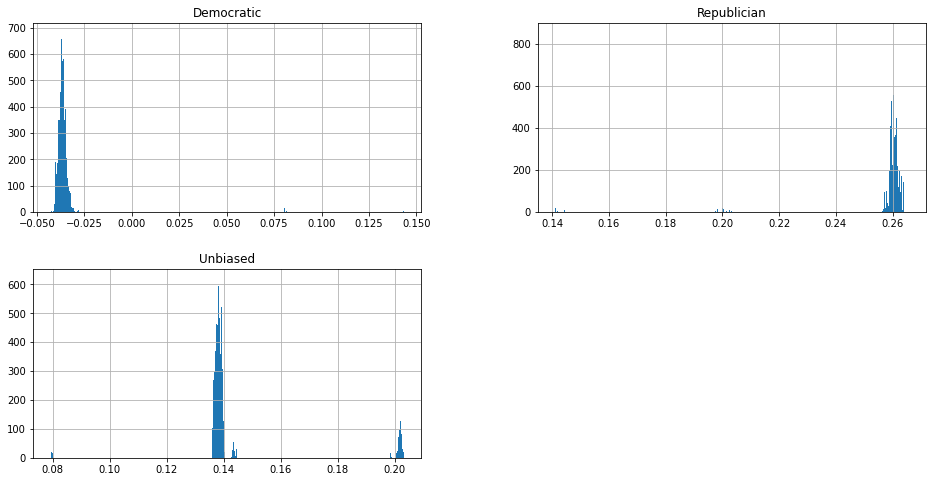

In [24]:
data_eg_PRES16.hist(bins=700, figsize = (16,8))

In [25]:
PRES16_mm = {"Democratic": mean_median_PRES16D, "Republician": mean_median_PRES16R, "Unbiased": mean_median_PRES16U}

data_mm_PRES16 = pd.DataFrame.from_dict(PRES16_mm)

Text(0.5, 0, 'Mean Median')

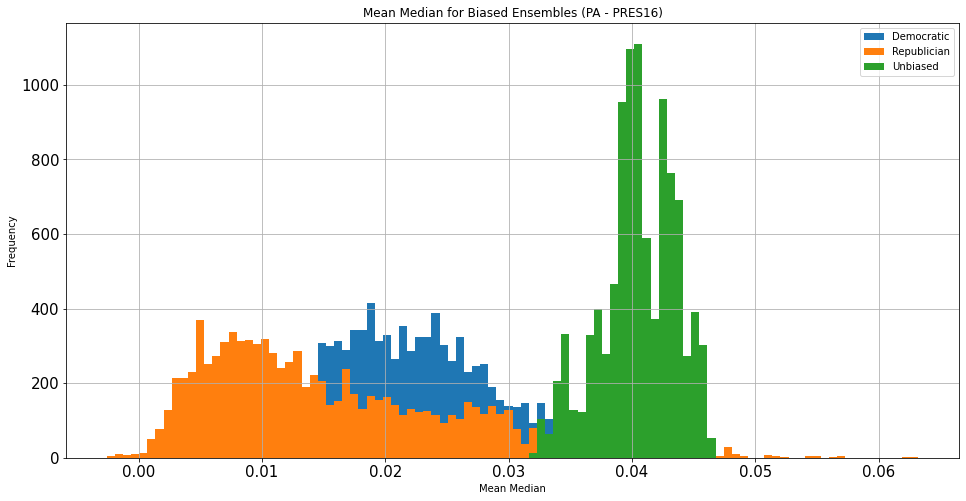

In [26]:
data_mm_PRES16.plot(kind='hist',
                    bins=100,
                    title = "Mean Median for Biased Ensembles (PA - PRES16)",
                    grid=True,
                    figsize = (16,8),
                    fontsize = 15)

plt.xlabel('Mean Median')

array([[<AxesSubplot:title={'center':'Democratic'}>,
        <AxesSubplot:title={'center':'Republician'}>],
       [<AxesSubplot:title={'center':'Unbiased'}>, <AxesSubplot:>]],
      dtype=object)

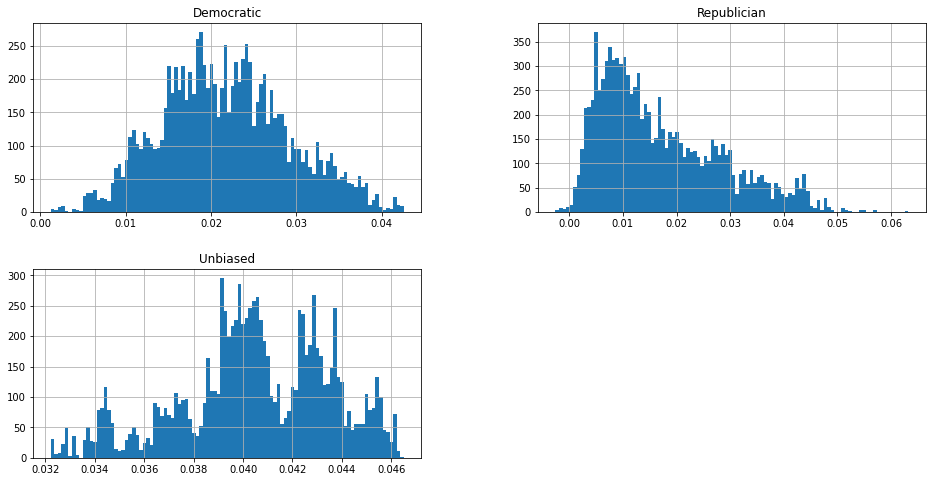

In [27]:
data_mm_PRES16.hist(bins=100, figsize = (16,8))

In [28]:
PRES16_mt = {"Democratic": mean_thirdian_PRES16D, "Republician": mean_thirdian_PRES16R, "Unbiased": mean_thirdian_PRES16U}

data_mt_PRES16 = pd.DataFrame.from_dict(PRES16_mt)

Text(0.5, 0, 'Mean Thirdian')

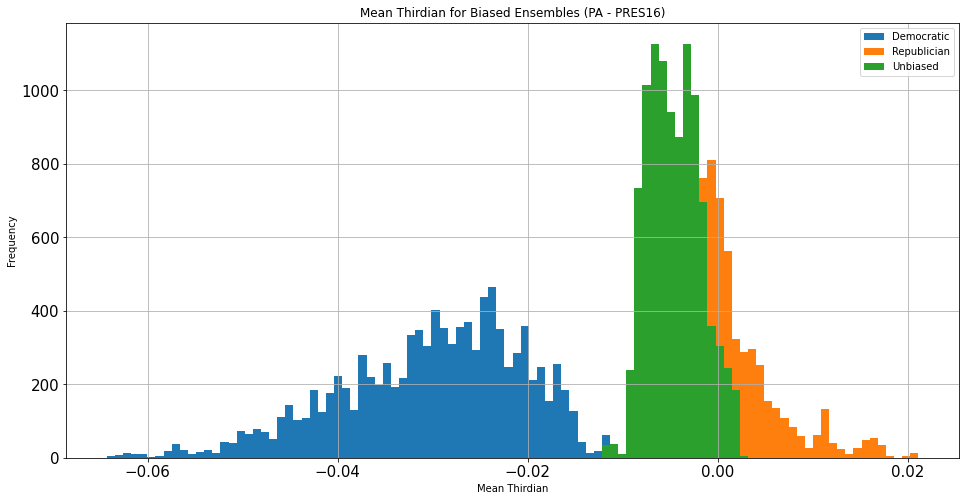

In [29]:
data_mt_PRES16.plot(kind='hist',
                    bins=100,
                    title = "Mean Thirdian for Biased Ensembles (PA - PRES16)",
                    grid=True,
                    figsize = (16,8),
                    fontsize = 15)

plt.xlabel('Mean Thirdian')

array([[<AxesSubplot:title={'center':'Democratic'}>,
        <AxesSubplot:title={'center':'Republician'}>],
       [<AxesSubplot:title={'center':'Unbiased'}>, <AxesSubplot:>]],
      dtype=object)

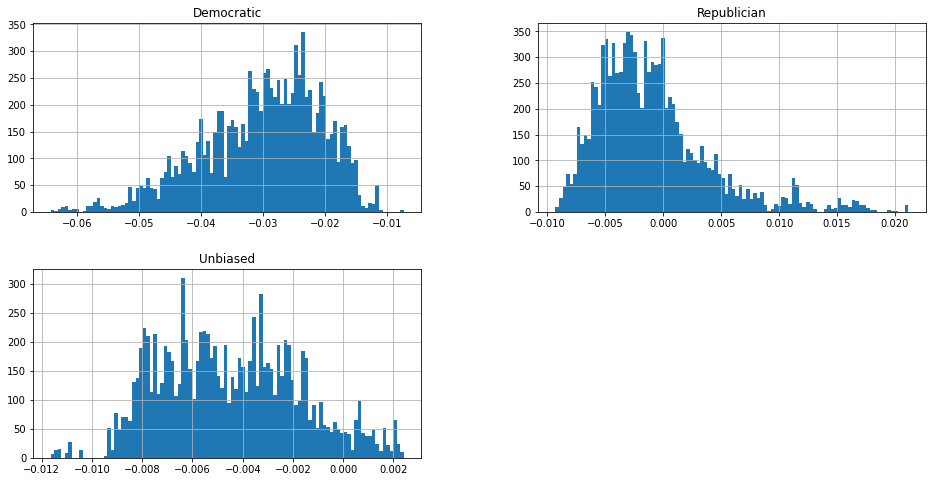

In [30]:
data_mt_PRES16.hist(bins=100, figsize = (16,8))

In [31]:
PRES16_pg = {"Democratic": partisan_gini_PRES16D, "Republician": partisan_gini_PRES16R, "Unbiased": partisan_gini_PRES16U}

data_pg_PRES16 = pd.DataFrame.from_dict(PRES16_pg)

Text(0.5, 0, 'Partisan Gini')

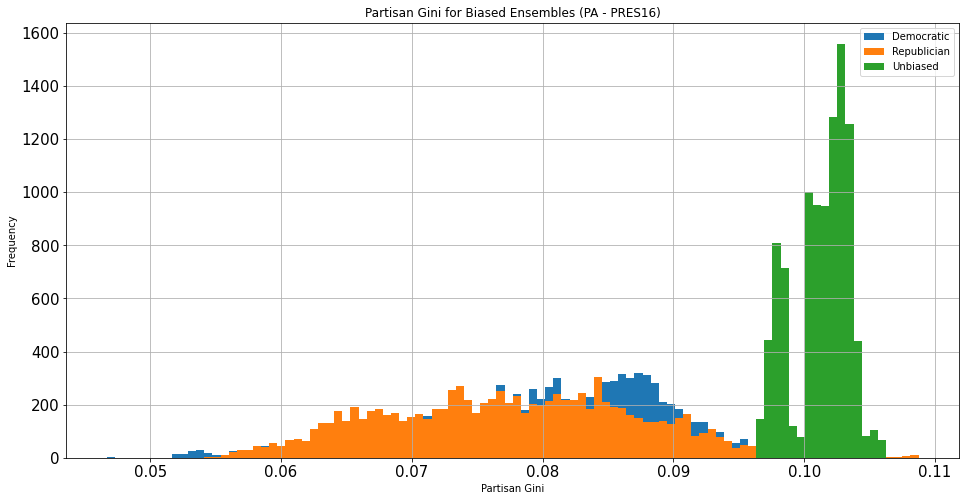

In [32]:
data_pg_PRES16.plot(kind='hist',
                    bins=100,
                    title = "Partisan Gini for Biased Ensembles (PA - PRES16)",
                    grid=True,
                    figsize = (16,8),
                    fontsize = 15)

plt.xlabel('Partisan Gini')

array([[<AxesSubplot:title={'center':'Democratic'}>,
        <AxesSubplot:title={'center':'Republician'}>],
       [<AxesSubplot:title={'center':'Unbiased'}>, <AxesSubplot:>]],
      dtype=object)

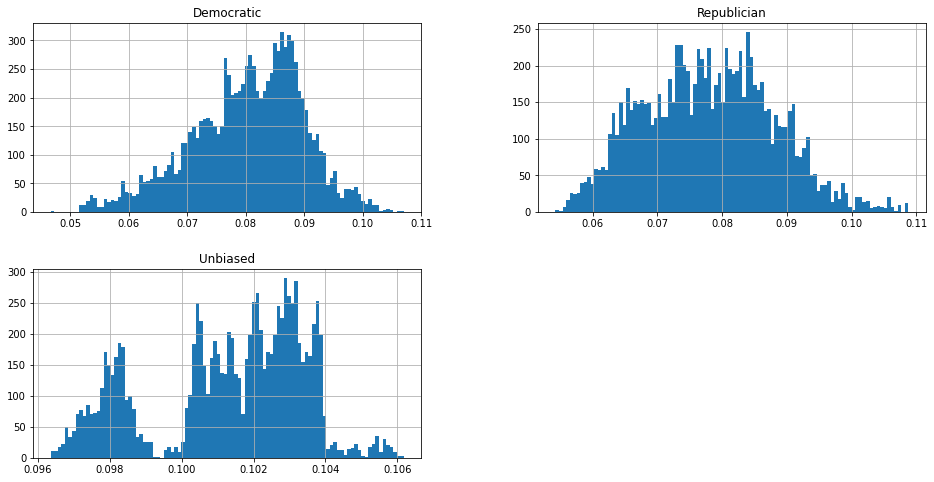

In [33]:
data_pg_PRES16.hist(bins=100, figsize = (16,8))

In [34]:
PRES16_pb = {"Democratic": partisan_bias_PRES16D, "Republician": partisan_bias_PRES16R, "Unbiased": partisan_gini_PRES16U}

data_pb_PRES16 = pd.DataFrame.from_dict(PRES16_pb)

Text(0.5, 0, 'Partisan Bias')

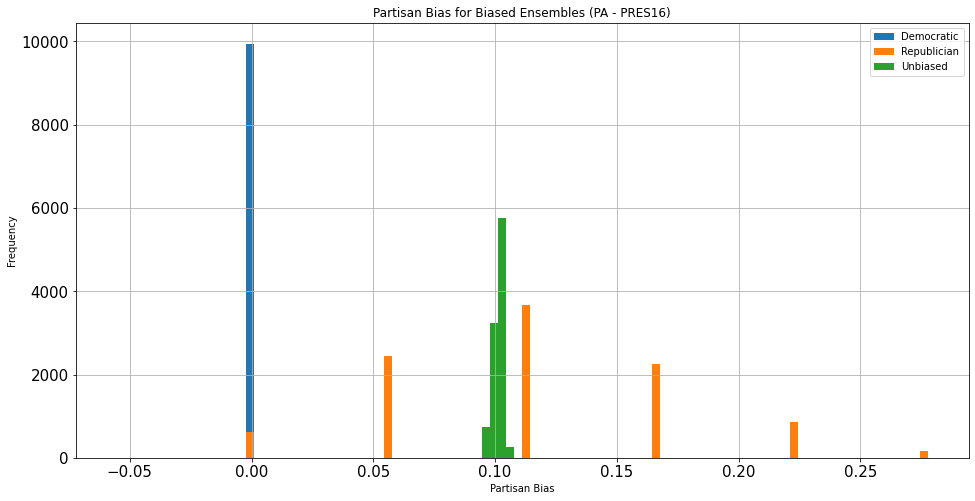

In [35]:
data_pb_PRES16.plot(kind='hist',
                    bins=100,
                    title = "Partisan Bias for Biased Ensembles (PA - PRES16)",
                    grid=True,
                    figsize = (16,8),
                    fontsize = 15)

plt.xlabel('Partisan Bias')

array([[<AxesSubplot:title={'center':'Democratic'}>,
        <AxesSubplot:title={'center':'Republician'}>],
       [<AxesSubplot:title={'center':'Unbiased'}>, <AxesSubplot:>]],
      dtype=object)

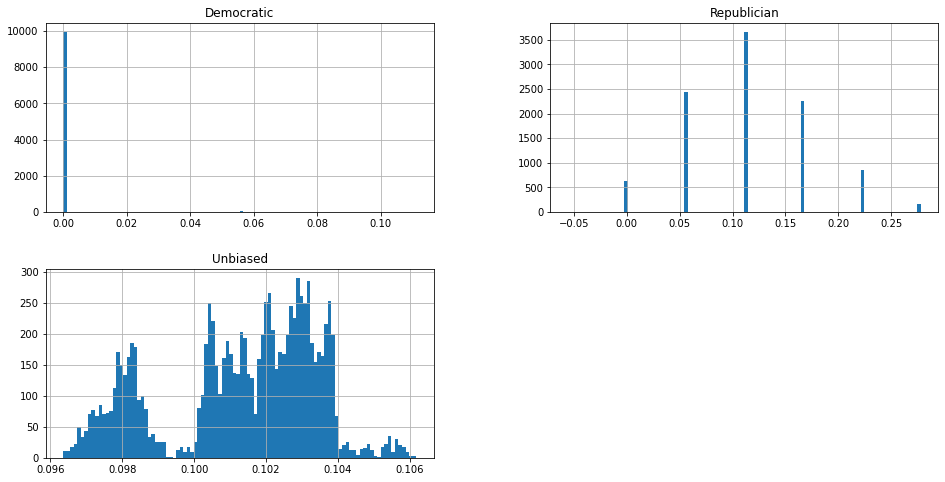

In [38]:
data_pb_PRES16.hist(bins=100, figsize = (16,8))

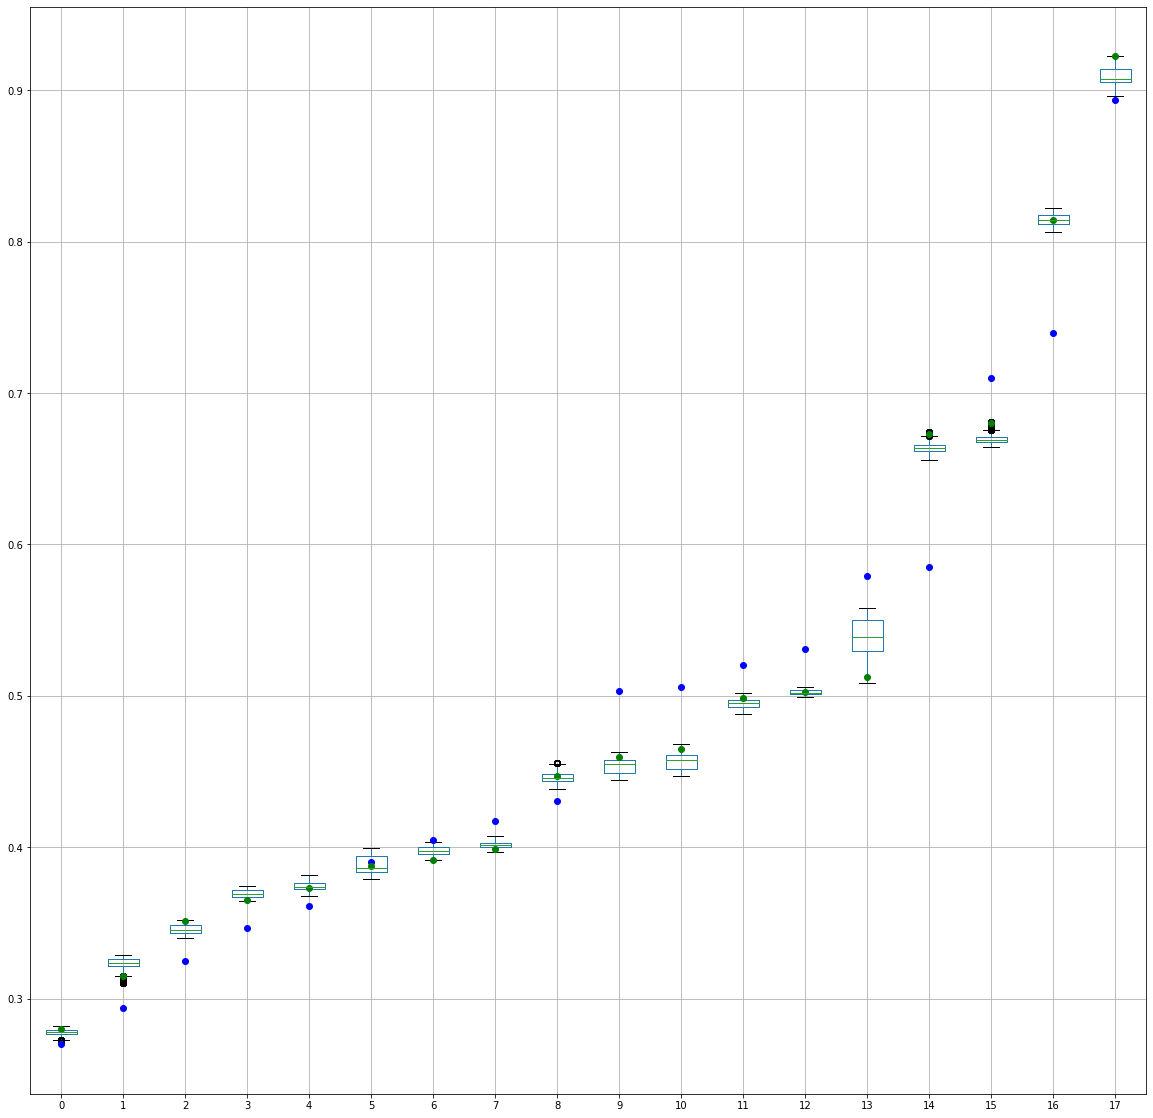

In [55]:
import matplotlib.pyplot as plt

ax = data_percents_PRES16DU.boxplot(positions=range(len(data_percents_PRES16DU.columns)),figsize=(20,20))
plt.plot(data_percents_PRES16D.iloc[9999], "bo")
plt.plot(data_percents_PRES16DU.iloc[0], "go" )
#plt.plot(data_percents_PRES16R.iloc[9999], "ro")

plt.show()

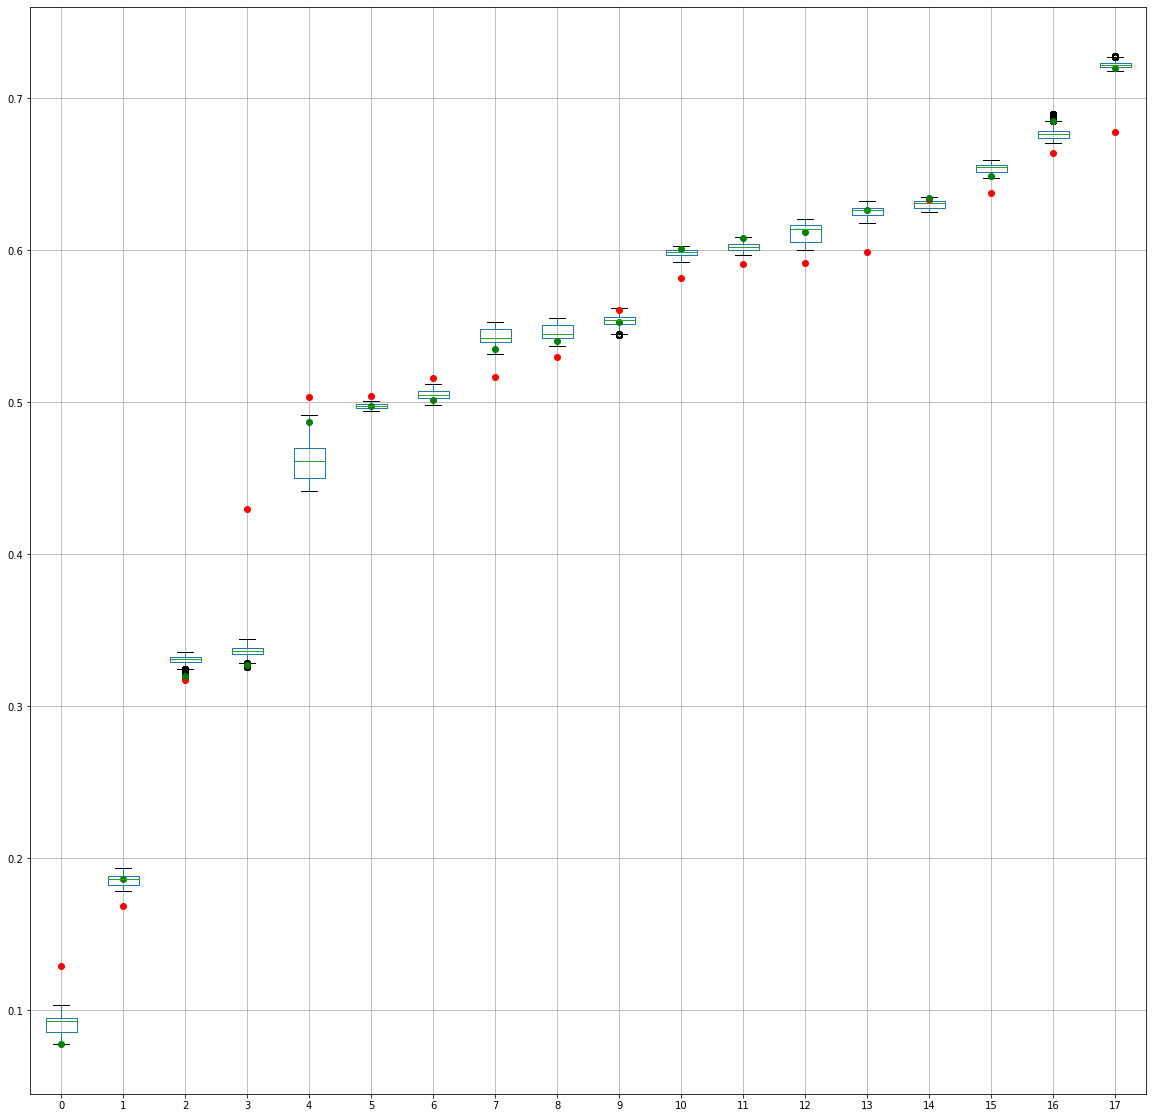

In [56]:
ax = data_percents_PRES16RU.boxplot(positions=range(len(data_percents_PRES16RU.columns)),figsize=(20,20))
plt.plot(data_percents_PRES16R.iloc[9999], "ro")
plt.plot(data_percents_PRES16RU.iloc[0], "go" )
#plt.plot(data_percents_PRES16R.iloc[9999], "ro")

plt.show()